# 2. Debris Flow Contributing Region

This notebook computes the contributing region (catchment, basin) for the debris flow locations in the [Staley *et al.* (2016)](https://pubs.er.usgs.gov/publication/ofr20161106) dataset.  It also adds the additional fuel-related features defined [by Roten *et al.*, 2022](https://ieeexplore.ieee.org/abstract/document/10020574).

This notebook follows the pysheds example shown in https://github.com/mdbartos/pysheds

It uses the 1/3 arc second data from the USGS:

https://tjwebb.medium.com/working-with-usgs-elevation-ned-3dep-data-and-postgis-c0fac3cd6c1b

The notebook uses Dask and may be deployed on a single workstation or node with running one or several dask threads, as well as on a cluster (e.g., Kubernetes)

In [1]:
import sys
sys.version

'3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]'

In [2]:
import pandas as pd
from shapely.geometry import Point
#import sqlalchemy as sa
import geopandas as gpd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [4]:
modelDataI=gpd.read_parquet("../../data/data_v01_add_site_ids.parquet")
#modelDataI.head()

In [5]:
modelDataI.loc[0,:]

fire_name                                                    Buckweed
year                                                             2007
fire_id                                                           bck
fire_segid                                                   bck_1035
database                                                     Training
state                                                              CA
response                                                            0
stormdate                                                  2008-01-22
gaugedist_m                                                   1998.67
stormstart                                        2008-01-21 16:27:00
stormend                                          2008-01-22 19:20:00
stormdur_h                                                     26.883
stormaccum_mm                                                     5.4
stormavgi_mmh                                                     0.2
peak_i15_mmh        

In [6]:
# each site should have the same contributing area regardless of event
assert(len(modelDataI["SiteID"].unique()) == len(modelDataI["contributingarea_km2"].unique()))

In [7]:
import pysheds
from pysheds.grid import Grid
from os import getpid
from posix import unlink

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Adding directory of fuel transformer module to path:

In [8]:
sys.path.append("../../Landfire/")

The warning about Fastfuels can be ignored.

In [9]:
from WifireFT import LandFire

In [10]:
import posix
import math
import rioxarray as rxr

In [11]:
bpath="https://wifire-data.sdsc.edu/data/landfire/"
mylf=LandFire(bpath=bpath, bpath_type="http")
#mylf=LandFire(bpath="/home/jovyan/pysheds//COG", bpath_type="local")

This displays the cloud-optimized GeoTiff files that are available from the link in `bpath`.  Here only `FBFM40` will be used; the elevation is not read from the `Elev` geotiffs but directly from the USGS in higher resolution.

In [12]:
mylf.avail_cog

{'CH': [210, 200, 140, 130, 120, 110, 105],
 'CC': [210, 200, 140, 130, 120, 110, 105],
 'CBD': [210, 200, 140, 130, 120, 110, 105],
 'CBH': [210, 200, 140, 130, 120, 110, 105],
 'FBFM40': [210, 200, 140, 130, 120, 110, 105],
 'FBFM13': [120, 110, 105],
 'EVT': [120, 110, 105],
 'Elev': [200]}

This function retrieves the DEM in 1/3 arc second (~10 m) resolution from the USGS.

In [13]:
math.pi * 6371*2 // 360.

111.0

In [14]:
def retrieve_usgs_13_topo(lon, lat, radius, verbose=False):
    if lon < 0:
        lonp=int(math.ceil(-lon))
        eow="w"
    else:
        lonp=int(math.ceil(lon))
        eow="e"

    latp=int(math.ceil(lat))
    
    urlmask="https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n%02d%c%03d/USGS_13_n%02d%c%03d.tif"
    url=urlmask % (latp, eow, lonp, latp, eow, lonp)
    if verbose:
        print(f"Retrieving DEM from {url}")
    
    asrc=rxr.open_rasterio(url)
    
    # The USGS DEM is provided in a different CRS (coordinate reference system) than the Landfire data 
    # (used for the fuel model).
    # The function `query` below extracts a rectangular mesh of a given radius around the provided point.
    # In order to obtain a reprojected mesh with the same CRS and region as the Landfire data, 
    # 3 steps are carried out.
    # 1. extract a subset that is larger (1.5x) than the intended area of interest from the Landfire DEM dataset.
    # 2. reproject the USGS DEM to this CRS
    # 3. extract a square region with the radius provided as positional argument from this DEM
              
    earths_radius = 6.371e6
    meters_per_deg=earths_radius * math.pi * 2 / 360.
    rad_deg=radius/meters_per_deg * 1.5
              
    if verbose:
        print(f"Quering USGS dataset for a radius of {rad_deg} degrees")
              
    outelev=mylf.query(asrc, lon, lat, rad_deg, verbose=verbose)
    
    outelev_utm=outelev.rio.reproject(outelev.rio.estimate_utm_crs())
    
    elev=mylf.query(outelev_utm, lon, lat, radius, verbose=verbose)
    
    return elev

Testing this function for the location of the first debris flow site:

In [15]:
elev=retrieve_usgs_13_topo(modelDataI.loc[0,"lon"], modelDataI.loc[0,"lat"], 1000, verbose=True)

Retrieving DEM from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n35w119/USGS_13_n35w119.tif
Quering USGS dataset for a radius of 0.01348982408878096 degrees
[-118.45056612601522, 34.55584754221625, -118.42358647783766, 34.52886789403869]
[367133.5165000012, 3824231.989, 369133.5165000012, 3822231.989]


Verifying resolution is correct:

In [16]:
elev.x[1].data-elev.x[0].data

9.4254316832521

Reading FBFM40 fuel model and existing vegetation type (EVT) from Landfire data:

In [17]:
#src=mylf.read_dataset(200, 'Elev', chunks=None)
fbfm40=mylf.read_dataset(210, 'FBFM40', chunks=None)
evt=mylf.read_dataset(120, 'EVT', chunks=None)

In [18]:
evt

<xarray.DataArray (band: 1, y: 97284, x: 154208)>
[15001971072 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.362e+06 -2.362e+06 ... 2.264e+06 2.264e+06
  * y            (y) float64 3.177e+06 3.177e+06 ... 2.59e+05 2.589e+05
    spatial_ref  int64 0
Attributes:
    DataSouce:      LandFire
    DataVersion:    L120 (2010, 2007-2011)
    FuelType:       EVT
    FuelDesc:       Existing Vegetation Type
    Units:          not yet implemented.
    AREA_OR_POINT:  Area
    LAYER_TYPE:     thematic
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      us_120evt

FBFM40 fuel model attributes.  Integer data values in this model are mapped to these layers:

In [19]:
fmattr=mylf.get_fbfm40_attributes(datatype='FBFM40')

In [20]:
fmattr[101],fmattr[102]

(('GR1',
  ' Short, sparse dry climate grass is short, naturally or heavy grazing, predicted rate of fire spread and flame length low'),
 ('GR2',
  ' Low load, dry climate grass primarily grass with some small amounts of fine, dead fuel, any shrubs do not affect fire behavior'))

Reducing data to a table with one row per site:

In [21]:
SiteProps=modelDataI[["lon","lat","geom","contributingarea_km2","SiteID"]].drop_duplicates().set_index("SiteID")
SiteProps.tail()

,lon,lat,geom,contributingarea_km2
SiteID,,,,
711,-109.270364,33.674955,POINT (-109.27036 33.67496),1.819213
712,-109.269682,33.674044,POINT (-109.26968 33.67404),2.325559
713,-109.261972,33.676641,POINT (-109.26197 33.67664),0.715387
714,-109.266936,33.654978,POINT (-109.26694 33.65498),1.554356
715,-109.272564,33.653975,POINT (-109.27256 33.65397),0.683425


This function takes an input array, which is the FBFM40 fuel type for the region around the debris flow, and has been multiplied with the catchment array.  Values outside of the catchment are zero.
The output is a dictionary with the relative contribution of each fuel category, and a categorical output with the dominant fuel type in the catchment.

In [22]:
def get_cat_contribs(clparr):
    fnums,cnt=np.unique(clparr, return_counts=True)
    
    #out={}
    odf=pd.DataFrame({"count": cnt, "fnum":fnums}).query("fnum > 0")
    
    #nft=len(ftypes)
    
    try:
        #ftypes=[fmattr[ft][0] for ft in fnums if ft != 0]
        odf["ftype"] = odf["fnum"].apply(lambda x: fmattr[x][0])
        odf["cat"] = odf["ftype"].str[0:2]

        cats=odf.groupby("cat")["count"].sum()
        cats = cats / cats.sum()

        #catd=cats.to_dict()

        allcats=["NB","GR","GS","SH","TU","TL"]

        for ca in allcats:
            if ca not in cats.index:
                cats[ca] = 0.

        # code of dominant fuel
        dfuel=odf.set_index("ftype")["count"].sort_values(ascending=False).index[0]
        
        cdict=cats.sort_index().to_dict()
    
    # if query region is empty
    except AttributeError:
        cdict={}
        dfuel='ER'
    
    return cdict, dfuel

In [23]:
def slope_from_elev(elv, dx, dy):
    px,py=np.gradient(elv, dx, dy)
    slope = np.sqrt(px**2 + py**2)
    return slope

In [24]:
try:
    import geojsoncontour
except ModuleNotFoundError:
    # you may need to change this to your version of python
    #!python3.8 -m pip install geojsoncontour
    !python3.9.12 -m pip install geojsoncontour
import json

Load a table that maps FBFM40 classes to fuel characteristics.  This should be included in the Landfire module as well.

In [25]:
fbpars=pd.read_pickle("../../Landfire/FBFM40_fuel_parameters.pkl").set_index("Num")
fbpars.head()

,Fine fuel load,SAV,Packing ratio,Extinction moisture content
Num,,,,
101,0.40,2054.0,0.00143,15.0
102,1.10,1820.0,0.00158,15.0
103,1.60,1290.0,0.00143,30.0
104,2.15,1826.0,0.00154,15.0
105,2.90,1631.0,0.00277,40.0


In [26]:
# map categorical numbers in matrix to numerical value corresponding to column col in dataframe valdf
def map_matrix(nummat, valdf, col):
    assert col in valdf.columns
    
    newmat=nummat.astype(float).copy()
    
    for cc in np.unique(newmat):
        idx = newmat == cc
        if cc in valdf.index:
            newmat[idx] = valdf.loc[cc,col]
        # use  value of zero for non-burnable fuels
        else:
            # these non-burnable fuels are not in the dataframe
            #assert cc in [91, 92, 93, 98, 99], f'unknown fuel {cc}'
            newmat[idx] = 0.
        
    return newmat

In [27]:
# retrieve average fuel parameters from FBFM40 fuel model for catchment area

def retrieve_avg_fuel_pars(catch, fmm):
    # first replace cat numbers with fuel type values
    fuelchar={}
    for fuel_par in fbpars.columns:
        fmat=map_matrix(fmm, fbpars, fuel_par) * np.array(catch)
        fuelchar[fuel_par] = fmat[fmat > 0].mean()
    return fuelchar

Function to extract contributing region (as polygon) given the coordinates of the debris flow base.
The contributing area is provided to estimate the size of the elevation extraction region needed.

Only one positional argument `tid` is provided, which is the id of the side in `SiteProps` table.  The catchment area is computed using the [pysheds](https://github.com/mdbartos/pysheds) library.

### Notes:

- The output is a matrix with zeros (outside catchment area) and ones (inside catchment area).  The polygon of the catchment area is then retrieved by making a contour plot (with a single contour at level 0.5), and transforming that contour into geojson format).  An alternative approach would be to keep coordinates of points inside the catchment as a list, and running the alphashape algorithm or concave hull on them.

- Because the reported debris flow location does not always coincide with the true location, the location is `clipped` to a place where the catchment area is at least a fraction of that reported by Staley.  In addition, the distance by which the catchment can be offset is limited using an iterative procedure (explained below).

In [28]:
def get_contributing_region(tid, acc_clip='range', slope_thres=25., verbose=False, debug_output=False, steep_only=False):
    lon=SiteProps.loc[tid,"lon"]
    lat=SiteProps.loc[tid,"lat"]
    carea=SiteProps.loc[tid, "contributingarea_km2"]
    
    #radius of DEM extraction is estimated based on catchment radius provided in Staley dataset
    radius = 6.*np.sqrt(carea) * 1.e3
    
    elev=retrieve_usgs_13_topo(lon, lat, radius, verbose=False)

    dx=abs(elev.x.data[1]-elev.x.data[0])
    dy=abs(elev.y.data[1]-elev.y.data[0])
    
    cell_area=dx*dy
    
    if verbose:
        print("cell_area:", cell_area)
    
    # write elevation to temporary tiff file that pysheds can read
    tmptifffile="/tmp/tmp-{}.tiff".format(getpid())
    elev.rio.to_raster(tmptifffile, dtype='float32')
    #print(tmptifffile)
    
    grid=Grid.from_raster(tmptifffile)
    dem=grid.read_raster(tmptifffile)
    pit_filled_dem = grid.fill_pits(dem)
    
    # Fill depressions in DEM
    flooded_dem = grid.fill_depressions(pit_filled_dem)
    
    # Resolve flats in DEM
    inflated_dem = grid.resolve_flats(flooded_dem)
    
    # flow direction
    fdir = grid.flowdir(inflated_dem)
    
    # compute flow accumulation over grid
    acc = grid.accumulation(fdir)#, dirmap=dirmap)
    
    # find nearby location with sufficiently high accumulation

    SiteProps_reproj=SiteProps.to_crs(elev.rio.crs)
    xp, yp = SiteProps_reproj.loc[tid,"geom"].x, SiteProps_reproj.loc[tid,"geom"].y 
    
    if verbose:
        print(xp,yp,elev.x.data[0],elev.x.data[-1],elev.y.data[0],elev.y.data[-1])
        
    # trying new approach
    # 1. snap to any value with area > 90% of target area
    #    if resulting area close to expected and
    #.   snap distance within threshold, keep
    
    # if snap distance > threshold:
    #    try clipping to smaller than expected area (50% or so?)
    #.   if this results in smaller snap distance, keep
    # 
    # if new area much greater than target area:
    #.   try clipping to range (50 - 150 % of target area)
    #.   if snap distance is within threshold, keep
    # 
    #.   otherwise, keep solution with smallest snap area
        
    
    snapmask = acc > (carea*1.e6 / cell_area * 0.9)
    xysnap, snap_dist1 = grid.snap_to_mask(snapmask, (xp, yp), return_dist=True)
    x_snap1, y_snap1 = xysnap
    catch1 = grid.catchment(x=x_snap1, y=y_snap1, fdir=fdir, xytype='coordinate')
    area1=catch1.sum() * cell_area * 1.e-6
    
    if (area1 > (carea * 3.)) | (snap_dist1 > 200.): 
        if verbose:
            print(f"area1 ({area1}) >> carea({carea}), trying range ...")
        lowthres  = carea*1.e6 / cell_area * 0.5
        highthres = carea*1.e6 / cell_area * 1.6
        snapmask = (acc > lowthres) & (acc < highthres)
        
        xysnap, snap_dist2 = grid.snap_to_mask(snapmask, (xp, yp), return_dist=True)
        x_snap2, y_snap2 = xysnap
        catch2 = grid.catchment(x=x_snap2, y=y_snap2, fdir=fdir, xytype='coordinate')
        area2=catch2.sum() * cell_area * 1.e-6
        
        if snap_dist2 < 200.:
            if verbose:
                print(f"    > new snap_dist2={snap_dist2}, keeping ....")
            catch=catch2
            area=area2
            snap_dist=snap_dist2
            
        else:
            if verbose:
                print(f"    > new snap_dist2={snap_dist2} (area2={area2}), rejecting ....")
            catch=catch1
            area=area1
            snap_dist=snap_dist1
            
    else:
        catch=catch1
        area=area1
        snap_dist=snap_dist1
    
  
    if verbose:
        print("Snap distance: {} m".format(snap_dist))
    
    # compute catchment area  
    
    if verbose:
        print("Area = " + str(area))
    
    slope = slope_from_elev(elev.data[0,:,:], dx, dy)
    slope_deg = np.degrees(np.arctan(slope))
    
    steepslope = slope_deg > slope_thres
    
    steepcatch = catch * steepslope
    
    steeparea = steepcatch.sum() * cell_area * 1.e-6
    
    if verbose:
        print(catch.shape, slope.shape, steeparea.shape)
    
    # retrieving a slightly larger area for the fuel models to avoid
    # gaps after reprojection
    fm=mylf.query(fbfm40, lon, lat, radius*1.5)
    fmr=fm.rio.reproject_match(elev)

    #ev=mylf.query(evt, lon, lat, radius*1.5)
    
    
    #unlink(tmptifffile)
    
    if steep_only:
        cats,dfuel=get_cat_contribs(fmr.data*steepcatch)
    else:
        cats,dfuel=get_cat_contribs(fmr.data*catch)
    
    # convert catchment area into shapely polygon, by creating a contour plot,
    # converting contours to geojson and then to a geodataframe,
    # and keeping the contour delineating the catchment
    
    fig,ax=plt.subplots()
    contourf=ax.contourf(elev.x.data, elev.y.data, catch, levels=[-0.5, 0.5, 1.5])
    
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf, ndigits=3, unit='m')
    
    catchgdf=gpd.GeoDataFrame.from_features(json.loads(geojson)).set_crs(elev.rio.crs)
    catchgdf=catchgdf.to_crs('epsg:4326')
    
    mask=catchgdf["title"] == "0.50-1.50 m"
    catchshape=catchgdf.loc[mask,"geometry"].iat[0]
    
    fuelpars=retrieve_avg_fuel_pars(catch, fmr.data)
    
    if not debug_output:
        return tid, cats, dfuel, area, snap_dist, catchshape,fuelpars

    else:
        return tid, elev, area, catch, snap_dist, slope_deg, steepslope, steepcatch, steeparea, fmr.data, cats, dfuel, catchshape, fuelpars
    
    ## DEV ##
    ## this could help with memory management ##
    # matplotlib.pyplot.close()

Testing the function on a list of random points:

In [29]:
if "ns" not in locals():
    ns=np.random.choice(SiteProps.index, size=1)
print(ns)

[712]


In [30]:
SiteProps

,lon,lat,geom,contributingarea_km2
SiteID,,,,
0,-118.437076,34.542358,POINT (-118.43708 34.54236),0.378767
1,-118.439898,34.540093,POINT (-118.43990 34.54009),0.689615
2,-118.443708,34.528844,POINT (-118.44371 34.52884),2.757312
3,-118.404930,34.558602,POINT (-118.40493 34.55860),0.613415
4,-118.408627,34.554817,POINT (-118.40863 34.55482),0.538875
...,...,...,...,...
711,-109.270364,33.674955,POINT (-109.27036 33.67496),1.819213
712,-109.269682,33.674044,POINT (-109.26968 33.67404),2.325559
713,-109.261972,33.676641,POINT (-109.26197 33.67664),0.715387


cell_area: 89.58762776932434
660408.3580999996 3727358.835 651260.942177594 669556.9304176942 3736510.9014574937 3718205.448143291
Snap distance: 9.77550537989946 m
Area = 2.302939559438251
(1935, 1934) (1935, 1934) ()
712 712 2.302939559438251 2.3255591


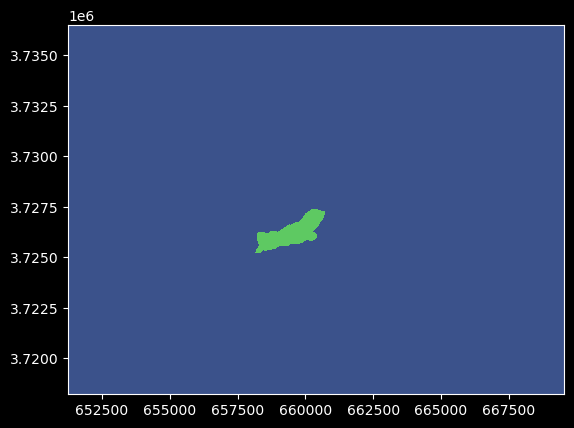

In [31]:
areas=[]

for n in ns:
    tid, elev, area, catch, snap_dist, slope, steepslope, steepcatch, steeparea, fm, cats, dfuel, catchshape, fuelpars = \
        get_contributing_region(n, acc_clip='range', debug_output=True, verbose=True)
    print(n, tid, area, SiteProps.loc[n,"contributingarea_km2"])
    areas.append(area)

In [32]:
fuelpars

{'Fine fuel load': 1.5959211857153974,
 'SAV': 1732.8905702948728,
 'Packing ratio': 0.009569539407142303,
 'Extinction moisture content': 17.115653932933945}

In [33]:
area,steeparea

(Raster(2.30293956), Raster(0.20963505))

In [34]:
type(elev)

xarray.core.dataarray.DataArray

Creating plots with: 
1. debris flow location over elevation map
1. catchment area as raster (1: inside, 0: outside catchment)
1. slope of terrain and site location
1. steep ($>$23$^\circ$) areas within catchment

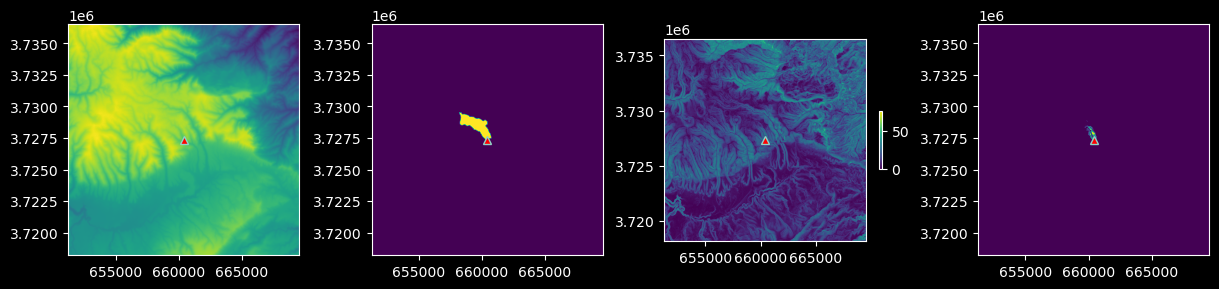

In [35]:
SiteProps_reproj=SiteProps.to_crs(elev.rio.crs)


fig,ax=plt.subplots(ncols=4, figsize=(15,3))
extent=[elev.x.min(), elev.x.max(), elev.y.min(), elev.y.max()]
ax[0].imshow(elev[0,:,:], origin='lower', extent=extent)

ax[1].imshow(catch, origin='lower', extent=extent)
h2=ax[2].imshow(slope, origin='lower', extent=extent)#, vmin=0, vmax=25.)
fig.colorbar(h2, ax=ax[2], shrink=0.25)
h3=ax[3].imshow(steepcatch, origin='lower', extent=extent)#, vmin=0, vmax=25.)

for p in range(4):
    ax[p].plot(SiteProps_reproj.loc[n,"geom"].x, SiteProps_reproj.loc[n,"geom"].y, marker='^',
          markerfacecolor='red')

Initiate dask client and distribute computation of features for all sites over several nodes:

In [36]:
from dask.distributed import Client
import dask.bag as db
import os

In [37]:
n_workers_avail = os.cpu_count()
n_workers_avail

48

In [38]:
# set the number of workers based on system configuration
# memory per worker should be at least 4.0GBs
# ideally would have between 10 - 20 workers but not take entire server's resources
if n_workers_avail > 30:
    n_workers = int(n_workers_avail / 3)    
else: n_workers = math.floor((n_workers_avail / 2) * .8) * 2 # don't take all the capacity

n_workers

16

In [39]:
# c=Client(n_workers=n_workers)
c=Client(
    n_workers=n_workers,
    threads_per_worker=n_workers/2
)

In [40]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128.0,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37681,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128.0
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:38825,Total threads: 8.0
Dashboard: http://127.0.0.1:43985/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:35401,


In [41]:
nworkers=len(c.get_worker_logs().keys())
nworkers

16

In [42]:
npartitions = int(nworkers / 2)
npartitions

8

In [43]:
# c.shutdown()

Function to get information about each node:

In [44]:
def nodeinfo(foo):
    import subprocess
    node=str(subprocess.run("hostname", capture_output=True).stdout).lstrip("b'").rstrip("\\n'")
    
    with open("/proc/cpuinfo","r") as fid:
        for n in range(5):
            nl=fid.readline()
    procname=nl.split(":")[1].rstrip("\n").lstrip()
    
    return (node,procname)

In [45]:
a=db.from_sequence(range(nworkers), npartitions=npartitions)
a

dask.bag<from_sequence, npartitions=8>

In [46]:
a.map(nodeinfo).compute()

[('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Intel(R) Xeon(R) Gold 6136 CPU @ 3.00GHz'),
 ('jupyter-ahohmann-40ucsd-2eedu', 'Inte

Total number of sites:

In [47]:
SiteIDs=SiteProps.index
print(len(SiteIDs))

716


In [48]:
b=db.from_sequence(SiteIDs, npartitions=npartitions)

In [49]:
b

dask.bag<from_sequence, npartitions=8>

In [50]:
# Consider using `matplotlib.pyplot.close()` in the `get_contributing_region` function

In [51]:
%%time
out=b.map(get_contributing_region).compute()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/tmp/ipykernel_19221/2784431435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

CPU times: user 1min 48s, sys: 40.6 s, total: 2min 29s
Wall time: 16min 9s


In [51]:
# %%time
# # persist is likely better for larger computation like this
# out=b.map(get_contributing_region).persist()

CPU times: user 74.5 ms, sys: 18.7 ms, total: 93.3 ms
Wall time: 87.7 ms


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/tmp/ipykernel_18212/2784431435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [55]:
type(out)

list

In [57]:
len(out)

716

In [65]:
# c.shutdown()

In [64]:
# c.shutdown()

The output dictionary contains a list for every site id with:
1. site id
1. dictionary with fractions vegetation types making out catchmnet
1. dominant vegetation type
1. area of catchment
1. distance debris flow location was shifted from original point (clip distance)
1. catchment polygon
1. dictionary with fuel parameters

In [58]:
out[-1]

(715,
 {'GR': 0.02894943673041656,
  'GS': 0.46528687450877654,
  'NB': 0.0,
  'SH': 0.08593135970657584,
  'TL': 0.32957820277705,
  'TU': 0.09025412627718103},
 'GS1',
 Raster(0.68403884),
 5.360731082556474,
 {'Fine fuel load': 1.8316478910138856,
  'SAV': 1709.367304165575,
  'Packing ratio': 0.012260784647629027,
  'Extinction moisture content': 18.278097982708935})

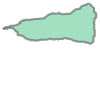

In [59]:
out[-1][5]

In [60]:
float(out[0][3])

0.3356328032688056

Checking for error in vegetation type:

In [61]:
[out[n][0] for n in range(len(out)) if out[n][2]=='ER']

[]

Save raw dask output to pickle:

In [62]:
import pickle

In [63]:
pickle.dump(out, open("../../data/dask_output_v3.pkl","wb"), protocol=0)

In [64]:
from shapely.ops import unary_union

Convert output given in list form to pandas dataframe

In [65]:
def out2df(out):
    
    allcats=["NB","GR","GS","SH","TU","TL"]
    fuelcats=["Fine fuel load", "SAV", "Packing ratio", "Extinction moisture content"]
    odf=gpd.GeoDataFrame(index=SiteIDs, columns=allcats + ['dom', 'newarea', 'snapdist','geometry'] + fuelcats)
    
    for n,ot in enumerate(out):
        idx=ot[0]
        for key in allcats:
            if key in ot[1].keys():
                odf.loc[idx,key] = ot[1][key]
            else:
                odf.loc[idx,key] = 0.
        odf.loc[idx,'dom'] = ot[2]
        odf.loc[idx,'newarea'] = float(ot[3])
        odf.loc[idx,'snapdist'] = float(ot[4])
        try:
            gidx=np.argmax([geom.area for geom in ot[5].geoms])
            odf.loc[idx,'geometry'] = ot[5].geoms[gidx]
        except:
            print("skipping entry %d" % n)

            
        for fc in fuelcats:
            odf.loc[idx,fc] = ot[6][fc]

    return odf

catsbysite=out2df(out)
catsbysite.tail(n=2)

,NB,GR,GS,SH,TU,TL,dom,newarea,snapdist,geometry,Fine fuel load,SAV,Packing ratio,Extinction moisture content
SiteID,,,,,,,,,,,,,,
714,0.0,0.177774,0.041012,0.009879,0.156307,0.615027,TL3,1.678057,5.732975,"POLYGON ((-109.26120 33.65589, -109.26115 33.6...",0.98505,1616.534444,0.01807,19.422728
715,0.0,0.028949,0.465287,0.085931,0.090254,0.329578,GS1,0.684039,5.360731,"POLYGON ((-109.27347 33.66086, -109.27337 33.6...",1.831648,1709.367304,0.012261,18.278098


In [66]:
catsbysite[catsbysite["geometry"] == None]

,NB,GR,GS,SH,TU,TL,dom,newarea,snapdist,geometry,Fine fuel load,SAV,Packing ratio,Extinction moisture content
SiteID,,,,,,,,,,,,,,


In [67]:
catsbysite.shape

(716, 14)

In [68]:
catsbysite.to_parquet("../../data/sites_v01_catchment_fuelpars.parquet")

Join this dataframe with the original dataframe with site parameters:

In [69]:
modelDataIF=modelDataI.join(catsbysite, on='SiteID')

In [70]:
modelDataIF.shape

(1550, 42)

In [71]:
modelDataIF.to_parquet("../../data/data_v02_catchment_fuelpars.parquet")

In [72]:
# shutdown dask client
c.shutdown()